In [1]:
import pandas as pd
import numpy as np
import sys, os
import matplotlib.pyplot as plt
import concurrent.futures
import importlib
import seaborn as sns
import scienceplots
import plot_loaders
import plot_utils

plt.style.use(["science","ieee"])
plt.rcParams.update({"axes.grid" : True})

First, define where the results are stored:

In [2]:
# The priority orders for colors/shapes display using seaborn.
ORDERINGS = {
    "noise_level": [
        x[0] for x in sorted(plot_loaders.NOISES_MAPPING.items(), key=lambda x: x[1])
    ][::1],
    "variant": ["nonoise", "zerosum", "muffliato"],
    "avgsteps": [i for i in range(20)][::1],
    "topology_type": ["static", "dynamic"],
    "additional_attribute": ["nonoise", "muffliato", "selfnoise", "noselfnoise"],
}
print(ORDERINGS)


target_dirs = []
target_dir = None

# MovieLens Experiments
target_dirs = [
    "my_results/movielens_full/",
    "my_results/movielens_1step_muffliato/",
    "my_results/movielens_10avgsteps_fullexperiment/"
]

# target_dirs = [
#     "my_results/PETS_revision/movielens_clipping/",
#     # "my_results/PETS_revision/movielens_clipping1_additionalnoises/",
#     "my_results/PETS_revision/movielens_clipping0.5/"
# ]
# target_dirs = [
#     "my_results/PETS_revision/movielens_64nodes/",
#     # "my_results/PETS_revision/movielens_32nodes/",
# ]

# target_dirs = ["my_results/PETS_revision/movielens_clipping_trials/"]
# target_dirs = ["my_results/PETS_revision/movielens_dropout_nonoisetrials/"]
# target_dirs = ["my_results/PETS_revision/movielens_dropout/"]

# Full CIFAR experiments, all combined:
# target_dirs = [
#     "my_results/cifar_GNRNet_fullexperiment/",
#     "my_results/cifar_iid_10avgsteps_2500iterations/"
#     # "my_results/PETS_revision/cifar_nonoise_10steps_confidence/",
# ]

# These will depend on the experiments. If attacks were computed, set those to TRUE. Runs only to for accuracy will set those to false.
LOAD_CLASSIFIER_RESULTS = True
LOAD_LINKABILITY_RESULTS = True
LOAD_THRESHOLD_RESULTS = True

# LOAD_CLASSIFIER_RESULTS = False
# LOAD_LINKABILITY_RESULTS = False
# LOAD_THRESHOLD_RESULTS = False


linestyles = {"ZeroSum": "--"}

fontsize = 20

alpha = 0.1

save_directory = "assets/"

{'noise_level': ['nonoise', '0th', '128th', '64th', '32th', '16th', '8th', '7th', '6th', '5th', '4th', '3p5th', '3th', '2p5th', '2th', '1th', '0p75th', '0p5th', '0p25th'], 'variant': ['nonoise', 'zerosum', 'muffliato'], 'avgsteps': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 'topology_type': ['static', 'dynamic'], 'additional_attribute': ['nonoise', 'muffliato', 'selfnoise', 'noselfnoise']}


Loading and listing all the experiments to consider 

In [3]:
# Load the file list
if target_dirs is None or len(target_dirs) == 0:
    assert target_dir is not None
    target_dirs = [target_dir]
experiments_dict = {}
experiments_attributes = {}
experiments_attributes_df = pd.DataFrame({})
for target_dir in target_dirs:
    experiments_dict.update(plot_loaders.get_full_path_dict(target_dir))
    experiments_attributes.update(plot_loaders.get_experiments_dict(experiments_dict))

    
    for experiment_name, experiment_attribute in sorted(experiments_attributes.items()):
        print(experiment_name)
        experiments_attributes_df = pd.concat(
            [
                experiments_attributes_df,
                pd.DataFrame(experiment_attribute, index=[experiment_name]),
            ]
        )

print(experiments_dict)

2484481_movielens_muffliato_100nodes_5avgsteps_128th_static_seed1234_MatrixFactorization_lr0.075_batchsize32
2484482_movielens_muffliato_100nodes_5avgsteps_128th_dynamic_seed1234_MatrixFactorization_lr0.075_batchsize32
2484483_movielens_muffliato_100nodes_5avgsteps_64th_static_seed1234_MatrixFactorization_lr0.075_batchsize32
2484484_movielens_muffliato_100nodes_5avgsteps_64th_dynamic_seed1234_MatrixFactorization_lr0.075_batchsize32
2484485_movielens_muffliato_100nodes_5avgsteps_32th_static_seed1234_MatrixFactorization_lr0.075_batchsize32
2484486_movielens_muffliato_100nodes_5avgsteps_32th_dynamic_seed1234_MatrixFactorization_lr0.075_batchsize32
2484487_movielens_muffliato_100nodes_5avgsteps_16th_static_seed1234_MatrixFactorization_lr0.075_batchsize32
2484488_movielens_muffliato_100nodes_5avgsteps_16th_dynamic_seed1234_MatrixFactorization_lr0.075_batchsize32
2484489_movielens_muffliato_100nodes_5avgsteps_8th_static_seed1234_MatrixFactorization_lr0.075_batchsize32
2484490_movielens_muffl

Actually loading the data in Dataframes:

In [4]:
importlib.reload(plot_loaders)
loaded_data = {}


with concurrent.futures.ProcessPoolExecutor(max_workers=20) as executor:
    futures = {}
    for name, filepath in sorted(experiments_dict.items()):
        futures[name] = executor.submit(plot_loaders.load_data_element, filepath)
    for name, result in futures.items():
        print(f"Adding data from {name}")
        res = result.result()
        if res.empty:
            print(f"Empty result for {name}")
        loaded_data[name] = res
print("Finished loading all data")
# for column in loaded_data[name]:
#     print(column)


Loading config file my_results/movielens_full/2484483_movielens_muffliato_100nodes_5avgsteps_64th_static_seed1234_MatrixFactorization_lr0.075_batchsize32/g5k_config.jsonLoading config file my_results/movielens_full/2484481_movielens_muffliato_100nodes_5avgsteps_128th_static_seed1234_MatrixFactorization_lr0.075_batchsize32/g5k_config.jsonLoading config file my_results/movielens_full/2484482_movielens_muffliato_100nodes_5avgsteps_128th_dynamic_seed1234_MatrixFactorization_lr0.075_batchsize32/g5k_config.jsonLoading config file my_results/movielens_full/2484486_movielens_muffliato_100nodes_5avgsteps_32th_dynamic_seed1234_MatrixFactorization_lr0.075_batchsize32/g5k_config.jsonLoading config file my_results/movielens_full/2484484_movielens_muffliato_100nodes_5avgsteps_64th_dynamic_seed1234_MatrixFactorization_lr0.075_batchsize32/g5k_config.jsonLoading config file my_results/movielens_full/2484487_movielens_muffliato_100nodes_5avgsteps_16th_static_seed1234_MatrixFactorization_lr0.075_batchsiz

## Aggregate data
Aggregate the loaded data to be displayed. We define some attributes that should be constants for a given experiment, as well as some other that should be automatically aggregated, using various aggregation methods (mean, min, max).

In [5]:
# Load at once since we'll pop from the dict, this should sanitize the for loop.
for experiment_name, experiment_data in list(loaded_data.items()):
    if experiment_data.empty:
        print(f"Deleting {experiment_name} as it did not load")
        loaded_data.pop(experiment_name)
        experiments_attributes.pop(experiment_name)


importlib.reload(plot_loaders)
# For most of the attacks
general_agg_methods = [
    "mean",
    "std",
    "sum",
    "min",
    "max",
    plot_loaders.percentile(0.5),
    plot_loaders.percentile(0.95),
]
columns_to_agg = [
    "train_loss",
    "test_loss",
    "test_acc",
    "total_bytes",
    "total_meta",
    "total_data_per_n",
]


if LOAD_THRESHOLD_RESULTS:
    columns_to_agg += [
        "roc_auc",
        "roc_auc_balanced",
        "50auc-distance",
        "50auc-distance_balanced",
    ]
if LOAD_CLASSIFIER_RESULTS:
    classifier_columns_to_agg = [
        "classifier_roc_auc",
    ]
    classifier_columns_to_agg += [
        f"classifier_tpr_at_fpr{fpr}" for fpr in [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
    ]
else:
    classifier_columns_to_agg = []
classifier_aggregator = {column: general_agg_methods for column in classifier_columns_to_agg}

if LOAD_LINKABILITY_RESULTS:
    linkability_aggregators = {
        "linkability_top1": ["median",plot_loaders.count_percentage_success],
        "linkability_top5": ["median",plot_loaders.count_percentage_success],
        "linkability_real_rank": ["median", "min", "max"],
    }
else:
    linkability_aggregators = {}

general_aggregator = {column: general_agg_methods for column in columns_to_agg}

formatted_data = {}
with concurrent.futures.ProcessPoolExecutor(max_workers=20) as executor:
    futures = {}
    for name, data in sorted(loaded_data.items()):
        print(f"Formatting {name}")
        futures[name] = executor.submit(plot_loaders.format_data,
            data=data,
            experiment_name=name,
            columns_to_agg=columns_to_agg,
            linkability_aggregators=linkability_aggregators,
            general_aggregators=general_aggregator,
            classifier_aggregator = classifier_aggregator,
            to_start_avg=[],
        )
    for name,future in futures.items():
        current_res = future.result()
        if current_res.empty:
            print(f"WARNING: Removed experiment {name}!!!!")
            experiments_attributes.pop(name)
        else:
            formatted_data[name] = current_res

formatted_data[list(formatted_data)[0]]

Formatting 2484481_movielens_muffliato_100nodes_5avgsteps_128th_static_seed1234_MatrixFactorization_lr0.075_batchsize32
Got error "['classifier_roc_auc', 'classifier_tpr_at_fpr1e-05', 'classifier_tpr_at_fpr0.0001', 'classifier_tpr_at_fpr0.001', 'classifier_tpr_at_fpr0.01', 'classifier_tpr_at_fpr0.1'] not in index" when loading the data, skipping!
Got error "['classifier_roc_auc', 'classifier_tpr_at_fpr1e-05', 'classifier_tpr_at_fpr0.0001', 'classifier_tpr_at_fpr0.001', 'classifier_tpr_at_fpr0.01', 'classifier_tpr_at_fpr0.1'] not in index" when loading the data, skipping!
Got error "['classifier_roc_auc', 'classifier_tpr_at_fpr1e-05', 'classifier_tpr_at_fpr0.0001', 'classifier_tpr_at_fpr0.001', 'classifier_tpr_at_fpr0.01', 'classifier_tpr_at_fpr0.1'] not in index" when loading the data, skipping!
Formatting 2484482_movielens_muffliato_100nodes_5avgsteps_128th_dynamic_seed1234_MatrixFactorization_lr0.075_batchsize32
Formatting 2484483_movielens_muffliato_100nodes_5avgsteps_64th_static_se

/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of

Got error "['classifier_roc_auc', 'classifier_tpr_at_fpr1e-05', 'classifier_tpr_at_fpr0.0001', 'classifier_tpr_at_fpr0.001', 'classifier_tpr_at_fpr0.01', 'classifier_tpr_at_fpr0.1'] not in index" when loading the data, skipping!

/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of

Got error "['classifier_roc_auc', 'classifier_tpr_at_fpr1e-05', 'classifier_tpr_at_fpr0.0001', 'classifier_tpr_at_fpr0.001', 'classifier_tpr_at_fpr0.01', 'classifier_tpr_at_fpr0.1'] not in index" when loading the data, skipping!


/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of

Got error "['classifier_roc_auc', 'classifier_tpr_at_fpr1e-05', 'classifier_tpr_at_fpr0.0001', 'classifier_tpr_at_fpr0.001', 'classifier_tpr_at_fpr0.01', 'classifier_tpr_at_fpr0.1'] not in index" when loading the data, skipping!

/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of

Got error "['classifier_roc_auc', 'classifier_tpr_at_fpr1e-05', 'classifier_tpr_at_fpr0.0001', 'classifier_tpr_at_fpr0.001', 'classifier_tpr_at_fpr0.01', 'classifier_tpr_at_fpr0.1'] not in index" when loading the data, skipping!

/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of

Got error "['classifier_roc_auc', 'classifier_tpr_at_fpr1e-05', 'classifier_tpr_at_fpr0.0001', 'classifier_tpr_at_fpr0.001', 'classifier_tpr_at_fpr0.01', 'classifier_tpr_at_fpr0.1'] not in index" when loading the data, skipping!

/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of

Got error "['classifier_roc_auc', 'classifier_tpr_at_fpr1e-05', 'classifier_tpr_at_fpr0.0001', 'classifier_tpr_at_fpr0.001', 'classifier_tpr_at_fpr0.01', 'classifier_tpr_at_fpr0.1'] not in index" when loading the data, skipping!

/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of

/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of

Got error "['classifier_roc_auc', 'classifier_tpr_at_fpr1e-05', 'classifier_tpr_at_fpr0.0001', 'classifier_tpr_at_fpr0.001', 'classifier_tpr_at_fpr0.01', 'classifier_tpr_at_fpr0.1'] not in index" when loading the data, skipping!

/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of

Got error "['classifier_roc_auc', 'classifier_tpr_at_fpr1e-05', 'classifier_tpr_at_fpr0.0001', 'classifier_tpr_at_fpr0.001', 'classifier_tpr_at_fpr0.01', 'classifier_tpr_at_fpr0.1'] not in index" when loading the data, skipping!


/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of

Got error "['classifier_roc_auc', 'classifier_tpr_at_fpr1e-05', 'classifier_tpr_at_fpr0.0001', 'classifier_tpr_at_fpr0.001', 'classifier_tpr_at_fpr0.01', 'classifier_tpr_at_fpr0.1'] not in index" when loading the data, skipping!


/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of

Got error "['classifier_roc_auc', 'classifier_tpr_at_fpr1e-05', 'classifier_tpr_at_fpr0.0001', 'classifier_tpr_at_fpr0.001', 'classifier_tpr_at_fpr0.01', 'classifier_tpr_at_fpr0.1'] not in index" when loading the data, skipping!

/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of

Got error "['classifier_roc_auc', 'classifier_tpr_at_fpr1e-05', 'classifier_tpr_at_fpr0.0001', 'classifier_tpr_at_fpr0.001', 'classifier_tpr_at_fpr0.01', 'classifier_tpr_at_fpr0.1'] not in index" when loading the data, skipping!


/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of

Got error "['classifier_roc_auc', 'classifier_tpr_at_fpr1e-05', 'classifier_tpr_at_fpr0.0001', 'classifier_tpr_at_fpr0.001', 'classifier_tpr_at_fpr0.01', 'classifier_tpr_at_fpr0.1'] not in index" when loading the data, skipping!

/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of

Got error "['classifier_roc_auc', 'classifier_tpr_at_fpr1e-05', 'classifier_tpr_at_fpr0.0001', 'classifier_tpr_at_fpr0.001', 'classifier_tpr_at_fpr0.01', 'classifier_tpr_at_fpr0.1'] not in index" when loading the data, skipping!

/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of

Got error "['classifier_roc_auc', 'classifier_tpr_at_fpr1e-05', 'classifier_tpr_at_fpr0.0001', 'classifier_tpr_at_fpr0.001', 'classifier_tpr_at_fpr0.01', 'classifier_tpr_at_fpr0.1'] not in index" when loading the data, skipping!


/home/dilereve/these/decentralizepy_grid5000/attacks/plot_loaders.py:828: PerformanceWarning: indexing past lexsort depth may impact performance.
  attack_data.reset_index(inplace=True)
/home/dilereve/these/decentralizepy_grid5000/attacks/plot_loaders.py:828: PerformanceWarning: indexing past lexsort depth may impact performance.
  attack_data.reset_index(inplace=True)
/home/dilereve/these/decentralizepy_grid5000/attacks/plot_loaders.py:828: PerformanceWarning: indexing past lexsort depth may impact performance.
  attack_data.reset_index(inplace=True)
/home/dilereve/these/decentralizepy_grid5000/attacks/plot_loaders.py:833: PerformanceWarning: indexing past lexsort depth may impact performance.
  usable_data.set_index("iteration", inplace=True)


Got error "['classifier_roc_auc', 'classifier_tpr_at_fpr1e-05', 'classifier_tpr_at_fpr0.0001', 'classifier_tpr_at_fpr0.001', 'classifier_tpr_at_fpr0.01', 'classifier_tpr_at_fpr0.1'] not in index" when loading the data, skipping!


/home/dilereve/these/decentralizepy_grid5000/attacks/plot_loaders.py:828: PerformanceWarning: indexing past lexsort depth may impact performance.
  attack_data.reset_index(inplace=True)
/home/dilereve/these/decentralizepy_grid5000/attacks/plot_loaders.py:828: PerformanceWarning: indexing past lexsort depth may impact performance.
  attack_data.reset_index(inplace=True)
/home/dilereve/these/decentralizepy_grid5000/attacks/plot_loaders.py:828: PerformanceWarning: indexing past lexsort depth may impact performance.
  attack_data.reset_index(inplace=True)
/home/dilereve/these/decentralizepy_grid5000/attacks/plot_loaders.py:833: PerformanceWarning: indexing past lexsort depth may impact performance.
  usable_data.set_index("iteration", inplace=True)
/home/dilereve/these/decentralizepy_grid5000/attacks/plot_loaders.py:828: PerformanceWarning: indexing past lexsort depth may impact performance.
  attack_data.reset_index(inplace=True)


Got error "['classifier_roc_auc', 'classifier_tpr_at_fpr1e-05', 'classifier_tpr_at_fpr0.0001', 'classifier_tpr_at_fpr0.001', 'classifier_tpr_at_fpr0.01', 'classifier_tpr_at_fpr0.1'] not in index" when loading the data, skipping!


/home/dilereve/these/decentralizepy_grid5000/attacks/plot_loaders.py:828: PerformanceWarning: indexing past lexsort depth may impact performance.
  attack_data.reset_index(inplace=True)
/home/dilereve/these/decentralizepy_grid5000/attacks/plot_loaders.py:828: PerformanceWarning: indexing past lexsort depth may impact performance.
  attack_data.reset_index(inplace=True)
/home/dilereve/these/decentralizepy_grid5000/attacks/plot_loaders.py:833: PerformanceWarning: indexing past lexsort depth may impact performance.
  usable_data.set_index("iteration", inplace=True)


Got error "['classifier_roc_auc', 'classifier_tpr_at_fpr1e-05', 'classifier_tpr_at_fpr0.0001', 'classifier_tpr_at_fpr0.001', 'classifier_tpr_at_fpr0.01', 'classifier_tpr_at_fpr0.1'] not in index" when loading the data, skipping!


/home/dilereve/these/decentralizepy_grid5000/attacks/plot_loaders.py:828: PerformanceWarning: indexing past lexsort depth may impact performance.
  attack_data.reset_index(inplace=True)
/home/dilereve/these/decentralizepy_grid5000/attacks/plot_loaders.py:828: PerformanceWarning: indexing past lexsort depth may impact performance.
  attack_data.reset_index(inplace=True)
/home/dilereve/these/decentralizepy_grid5000/attacks/plot_loaders.py:828: PerformanceWarning: indexing past lexsort depth may impact performance.
  attack_data.reset_index(inplace=True)
/home/dilereve/these/decentralizepy_grid5000/attacks/plot_loaders.py:833: PerformanceWarning: indexing past lexsort depth may impact performance.
  usable_data.set_index("iteration", inplace=True)


Got error "['classifier_roc_auc', 'classifier_tpr_at_fpr1e-05', 'classifier_tpr_at_fpr0.0001', 'classifier_tpr_at_fpr0.001', 'classifier_tpr_at_fpr0.01', 'classifier_tpr_at_fpr0.1'] not in index" when loading the data, skipping!


/home/dilereve/these/decentralizepy_grid5000/attacks/plot_loaders.py:828: PerformanceWarning: indexing past lexsort depth may impact performance.
  attack_data.reset_index(inplace=True)
/home/dilereve/these/decentralizepy_grid5000/attacks/plot_loaders.py:828: PerformanceWarning: indexing past lexsort depth may impact performance.
  attack_data.reset_index(inplace=True)
/home/dilereve/these/decentralizepy_grid5000/attacks/plot_loaders.py:828: PerformanceWarning: indexing past lexsort depth may impact performance.
  attack_data.reset_index(inplace=True)
/home/dilereve/these/decentralizepy_grid5000/attacks/plot_loaders.py:828: PerformanceWarning: indexing past lexsort depth may impact performance.
  attack_data.reset_index(inplace=True)
/home/dilereve/these/decentralizepy_grid5000/attacks/plot_loaders.py:833: PerformanceWarning: indexing past lexsort depth may impact performance.
  usable_data.set_index("iteration", inplace=True)


Got error "['classifier_roc_auc', 'classifier_tpr_at_fpr1e-05', 'classifier_tpr_at_fpr0.0001', 'classifier_tpr_at_fpr0.001', 'classifier_tpr_at_fpr0.01', 'classifier_tpr_at_fpr0.1'] not in index" when loading the data, skipping!


/home/dilereve/these/decentralizepy_grid5000/attacks/plot_loaders.py:828: PerformanceWarning: indexing past lexsort depth may impact performance.
  attack_data.reset_index(inplace=True)
/home/dilereve/these/decentralizepy_grid5000/attacks/plot_loaders.py:828: PerformanceWarning: indexing past lexsort depth may impact performance.
  attack_data.reset_index(inplace=True)
/home/dilereve/these/decentralizepy_grid5000/attacks/plot_loaders.py:828: PerformanceWarning: indexing past lexsort depth may impact performance.
  attack_data.reset_index(inplace=True)
/home/dilereve/these/decentralizepy_grid5000/attacks/plot_loaders.py:828: PerformanceWarning: indexing past lexsort depth may impact performance.
  attack_data.reset_index(inplace=True)
/home/dilereve/these/decentralizepy_grid5000/attacks/plot_loaders.py:833: PerformanceWarning: indexing past lexsort depth may impact performance.
  usable_data.set_index("iteration", inplace=True)


Got error "['classifier_roc_auc', 'classifier_tpr_at_fpr1e-05', 'classifier_tpr_at_fpr0.0001', 'classifier_tpr_at_fpr0.001', 'classifier_tpr_at_fpr0.01', 'classifier_tpr_at_fpr0.1'] not in index" when loading the data, skipping!


/home/dilereve/these/decentralizepy_grid5000/attacks/plot_loaders.py:828: PerformanceWarning: indexing past lexsort depth may impact performance.
  attack_data.reset_index(inplace=True)
/home/dilereve/these/decentralizepy_grid5000/attacks/plot_loaders.py:828: PerformanceWarning: indexing past lexsort depth may impact performance.
  attack_data.reset_index(inplace=True)
/home/dilereve/these/decentralizepy_grid5000/attacks/plot_loaders.py:828: PerformanceWarning: indexing past lexsort depth may impact performance.
  attack_data.reset_index(inplace=True)
/home/dilereve/these/decentralizepy_grid5000/attacks/plot_loaders.py:828: PerformanceWarning: indexing past lexsort depth may impact performance.
  attack_data.reset_index(inplace=True)
/home/dilereve/these/decentralizepy_grid5000/attacks/plot_loaders.py:833: PerformanceWarning: indexing past lexsort depth may impact performance.
  usable_data.set_index("iteration", inplace=True)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/l

Got error "['classifier_roc_auc', 'classifier_tpr_at_fpr1e-05', 'classifier_tpr_at_fpr0.0001', 'classifier_tpr_at_fpr0.001', 'classifier_tpr_at_fpr0.01', 'classifier_tpr_at_fpr0.1'] not in index" when loading the data, skipping!

/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of

Got error "['classifier_roc_auc', 'classifier_tpr_at_fpr1e-05', 'classifier_tpr_at_fpr0.0001', 'classifier_tpr_at_fpr0.001', 'classifier_tpr_at_fpr0.01', 'classifier_tpr_at_fpr0.1'] not in index" when loading the data, skipping!

/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/these/decentralizepy_grid5000/attacks/plot_loaders.py:828: PerformanceWarning: indexing past lexsort depth may impact performance

Got error "['classifier_roc_auc', 'classifier_tpr_at_fpr1e-05', 'classifier_tpr_at_fpr0.0001', 'classifier_tpr_at_fpr0.001', 'classifier_tpr_at_fpr0.01', 'classifier_tpr_at_fpr0.1'] not in index" when loading the data, skipping!


/home/dilereve/these/decentralizepy_grid5000/attacks/plot_loaders.py:828: PerformanceWarning: indexing past lexsort depth may impact performance.
  attack_data.reset_index(inplace=True)
/home/dilereve/these/decentralizepy_grid5000/attacks/plot_loaders.py:828: PerformanceWarning: indexing past lexsort depth may impact performance.
  attack_data.reset_index(inplace=True)
/home/dilereve/these/decentralizepy_grid5000/attacks/plot_loaders.py:828: PerformanceWarning: indexing past lexsort depth may impact performance.
  attack_data.reset_index(inplace=True)
/home/dilereve/these/decentralizepy_grid5000/attacks/plot_loaders.py:833: PerformanceWarning: indexing past lexsort depth may impact performance.
  usable_data.set_index("iteration", inplace=True)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv

Got error "['classifier_roc_auc', 'classifier_tpr_at_fpr1e-05', 'classifier_tpr_at_fpr0.0001', 'classifier_tpr_at_fpr0.001', 'classifier_tpr_at_fpr0.01', 'classifier_tpr_at_fpr0.1'] not in index" when loading the data, skipping!

/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of

Got error "['classifier_roc_auc', 'classifier_tpr_at_fpr1e-05', 'classifier_tpr_at_fpr0.0001', 'classifier_tpr_at_fpr0.001', 'classifier_tpr_at_fpr0.01', 'classifier_tpr_at_fpr0.1'] not in index" when loading the data, skipping!


/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of

Got error "['classifier_roc_auc', 'classifier_tpr_at_fpr1e-05', 'classifier_tpr_at_fpr0.0001', 'classifier_tpr_at_fpr0.001', 'classifier_tpr_at_fpr0.01', 'classifier_tpr_at_fpr0.1'] not in index" when loading the data, skipping!


/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of

/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/these/decentralizepy_grid5000/attacks/plot_loaders.py:828: PerformanceWarning: indexing past lexsort depth may impact performance.
  attack_data.reset_index(inplace=True)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nan

Got error "['classifier_roc_auc', 'classifier_tpr_at_fpr1e-05', 'classifier_tpr_at_fpr0.0001', 'classifier_tpr_at_fpr0.001', 'classifier_tpr_at_fpr0.01', 'classifier_tpr_at_fpr0.1'] not in index" when loading the data, skipping!


/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of

Got error "['classifier_roc_auc', 'classifier_tpr_at_fpr1e-05', 'classifier_tpr_at_fpr0.0001', 'classifier_tpr_at_fpr0.001', 'classifier_tpr_at_fpr0.01', 'classifier_tpr_at_fpr0.1'] not in index" when loading the data, skipping!

/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of

Got error "['classifier_roc_auc', 'classifier_tpr_at_fpr1e-05', 'classifier_tpr_at_fpr0.0001', 'classifier_tpr_at_fpr0.001', 'classifier_tpr_at_fpr0.01', 'classifier_tpr_at_fpr0.1'] not in index" when loading the data, skipping!

/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of

Got error "['classifier_roc_auc', 'classifier_tpr_at_fpr1e-05', 'classifier_tpr_at_fpr0.0001', 'classifier_tpr_at_fpr0.001', 'classifier_tpr_at_fpr0.01', 'classifier_tpr_at_fpr0.1'] not in index" when loading the data, skipping!

/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of

Got error "['classifier_roc_auc', 'classifier_tpr_at_fpr1e-05', 'classifier_tpr_at_fpr0.0001', 'classifier_tpr_at_fpr0.001', 'classifier_tpr_at_fpr0.01', 'classifier_tpr_at_fpr0.1'] not in index" when loading the data, skipping!

/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of

/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of

Got error "['classifier_roc_auc', 'classifier_tpr_at_fpr1e-05', 'classifier_tpr_at_fpr0.0001', 'classifier_tpr_at_fpr0.001', 'classifier_tpr_at_fpr0.01', 'classifier_tpr_at_fpr0.1'] not in index" when loading the data, skipping!

/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of

/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of

Got error "['classifier_roc_auc', 'classifier_tpr_at_fpr1e-05', 'classifier_tpr_at_fpr0.0001', 'classifier_tpr_at_fpr0.001', 'classifier_tpr_at_fpr0.01', 'classifier_tpr_at_fpr0.1'] not in index" when loading the data, skipping!

/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of

Got error "['classifier_roc_auc', 'classifier_tpr_at_fpr1e-05', 'classifier_tpr_at_fpr0.0001', 'classifier_tpr_at_fpr0.001', 'classifier_tpr_at_fpr0.01', 'classifier_tpr_at_fpr0.1'] not in index" when loading the data, skipping!

/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of

Got error "['classifier_roc_auc', 'classifier_tpr_at_fpr1e-05', 'classifier_tpr_at_fpr0.0001', 'classifier_tpr_at_fpr0.001', 'classifier_tpr_at_fpr0.01', 'classifier_tpr_at_fpr0.1'] not in index" when loading the data, skipping!


/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of

Got error "['classifier_roc_auc', 'classifier_tpr_at_fpr1e-05', 'classifier_tpr_at_fpr0.0001', 'classifier_tpr_at_fpr0.001', 'classifier_tpr_at_fpr0.01', 'classifier_tpr_at_fpr0.1'] not in index" when loading the data, skipping!


/home/dilereve/these/decentralizepy_grid5000/attacks/plot_loaders.py:828: PerformanceWarning: indexing past lexsort depth may impact performance.
  attack_data.reset_index(inplace=True)
/home/dilereve/these/decentralizepy_grid5000/attacks/plot_loaders.py:828: PerformanceWarning: indexing past lexsort depth may impact performance.
  attack_data.reset_index(inplace=True)
/home/dilereve/these/decentralizepy_grid5000/attacks/plot_loaders.py:828: PerformanceWarning: indexing past lexsort depth may impact performance.
  attack_data.reset_index(inplace=True)
/home/dilereve/these/decentralizepy_grid5000/attacks/plot_loaders.py:828: PerformanceWarning: indexing past lexsort depth may impact performance.
  attack_data.reset_index(inplace=True)
/home/dilereve/these/decentralizepy_grid5000/attacks/plot_loaders.py:833: PerformanceWarning: indexing past lexsort depth may impact performance.
  usable_data.set_index("iteration", inplace=True)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/l

/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of

/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of

Got error "['classifier_roc_auc', 'classifier_tpr_at_fpr1e-05', 'classifier_tpr_at_fpr0.0001', 'classifier_tpr_at_fpr0.001', 'classifier_tpr_at_fpr0.01', 'classifier_tpr_at_fpr0.1'] not in index" when loading the data, skipping!

/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of

/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of

/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of

/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of

/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/dilereve/python_envs/venv-python3.10-decentralizepy/lib64/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of

,experience_name,train_loss mean,train_loss std,train_loss sum,train_loss min,train_loss max,train_loss PercentileAggregator,train_loss PercentileAggregator,test_loss mean,test_loss std,...,noise_level,variant,additional_attribute,topology_type,partition_niid,clipping_norm,noise_level_value,log_noise,low_noise_mult,communication_step
iteration,,,,,,,,,,,,,,,,,,,,,
1,2484481_movielens_muffliato_100nodes_5avgsteps...,13.990442,1.953651,1399.044222,7.698236,18.215655,14.157397,16.945495,3.729401,0.261289,...,128th,muffliato,muffliato,static,None,None,0.001758,0,1.0,5
1,2484481_movielens_muffliato_100nodes_5avgsteps...,13.990442,1.953651,1399.044222,7.698236,18.215655,14.157397,16.945495,3.729401,0.261289,...,128th,muffliato,muffliato,static,None,None,0.001758,0,1.0,5
1,2484481_movielens_muffliato_100nodes_5avgsteps...,13.990442,1.953651,1399.044222,7.698236,18.215655,14.157397,16.945495,3.729401,0.261289,...,128th,muffliato,muffliato,static,None,None,0.001758,0,1.0,5
1,2484481_movielens_muffliato_100nodes_5avgsteps...,13.990442,1.953651,1399.044222,7.698236,18.215655,14.157397,16.945495,3.729401,0.261289,...,128th,muffliato,muffliato,static,None,None,0.001758,0,1.0,5
1,2484481_movielens_muffliato_100nodes_5avgsteps...,13.990442,1.953651,1399.044222,7.698236,18.215655,14.157397,16.945495,3.729401,0.261289,...,128th,muffliato,muffliato,static,None,None,0.001758,0,1.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5000,2484481_movielens_muffliato_100nodes_5avgsteps...,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,128th,muffliato,muffliato,static,None,None,0.001758,0,1.0,25000
5000,2484481_movielens_muffliato_100nodes_5avgsteps...,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,128th,muffliato,muffliato,static,None,None,0.001758,0,1.0,25000
5000,2484481_movielens_muffliato_100nodes_5avgsteps...,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,128th,muffliato,muffliato,static,None,None,0.001758,0,1.0,25000


List the columns in the final dataframe:

In [6]:
for c in formatted_data[list(formatted_data)[0]].columns:
    print(c)
print([x for x in formatted_data[list(formatted_data)[0]].columns if "classifier" in x])


experience_name
train_loss mean
train_loss std
train_loss sum
train_loss min
train_loss max
train_loss PercentileAggregator
train_loss PercentileAggregator
test_loss mean
test_loss std
test_loss sum
test_loss min
test_loss max
test_loss PercentileAggregator
test_loss PercentileAggregator
test_acc mean
test_acc std
test_acc sum
test_acc min
test_acc max
test_acc PercentileAggregator
test_acc PercentileAggregator
total_bytes mean
total_bytes std
total_bytes sum
total_bytes min
total_bytes max
total_bytes PercentileAggregator
total_bytes PercentileAggregator
total_meta mean
total_meta std
total_meta sum
total_meta min
total_meta max
total_meta PercentileAggregator
total_meta PercentileAggregator
total_data_per_n mean
total_data_per_n std
total_data_per_n sum
total_data_per_n min
total_data_per_n max
total_data_per_n PercentileAggregator
total_data_per_n PercentileAggregator
roc_auc mean
roc_auc std
roc_auc sum
roc_auc min
roc_auc max
roc_auc PercentileAggregator
roc_auc PercentileAggregat

## First display example: Tradeoff plots
Those are the main displays used in the paper. They display tradeoffs directly.

To use this, we have to name the x axis, the y axis, as well as the aggregation method we want to use.
We start by displaying the classifier attack results.

2500318_movielens_nonoise_1avgsteps_static_seed1234_MatrixFactorization_lr0.075_batchsize32
2500320_movielens_zerosum_selfnoise_1avgsteps_128th_static_seed1234_MatrixFactorization_lr0.075_batchsize32
2500322_movielens_zerosum_selfnoise_1avgsteps_64th_static_seed1234_MatrixFactorization_lr0.075_batchsize32
2500324_movielens_zerosum_selfnoise_1avgsteps_32th_static_seed1234_MatrixFactorization_lr0.075_batchsize32
2500328_movielens_zerosum_selfnoise_1avgsteps_16th_static_seed1234_MatrixFactorization_lr0.075_batchsize32
2500330_movielens_zerosum_selfnoise_1avgsteps_8th_static_seed1234_MatrixFactorization_lr0.075_batchsize32
2500332_movielens_zerosum_selfnoise_1avgsteps_4th_static_seed1234_MatrixFactorization_lr0.075_batchsize32
2500334_movielens_zerosum_selfnoise_1avgsteps_2th_static_seed1234_MatrixFactorization_lr0.075_batchsize32
2500336_movielens_zerosum_selfnoise_1avgsteps_1th_static_seed1234_MatrixFactorization_lr0.075_batchsize32
2500338_movielens_zerosum_selfnoise_1avgsteps_0p25th_st

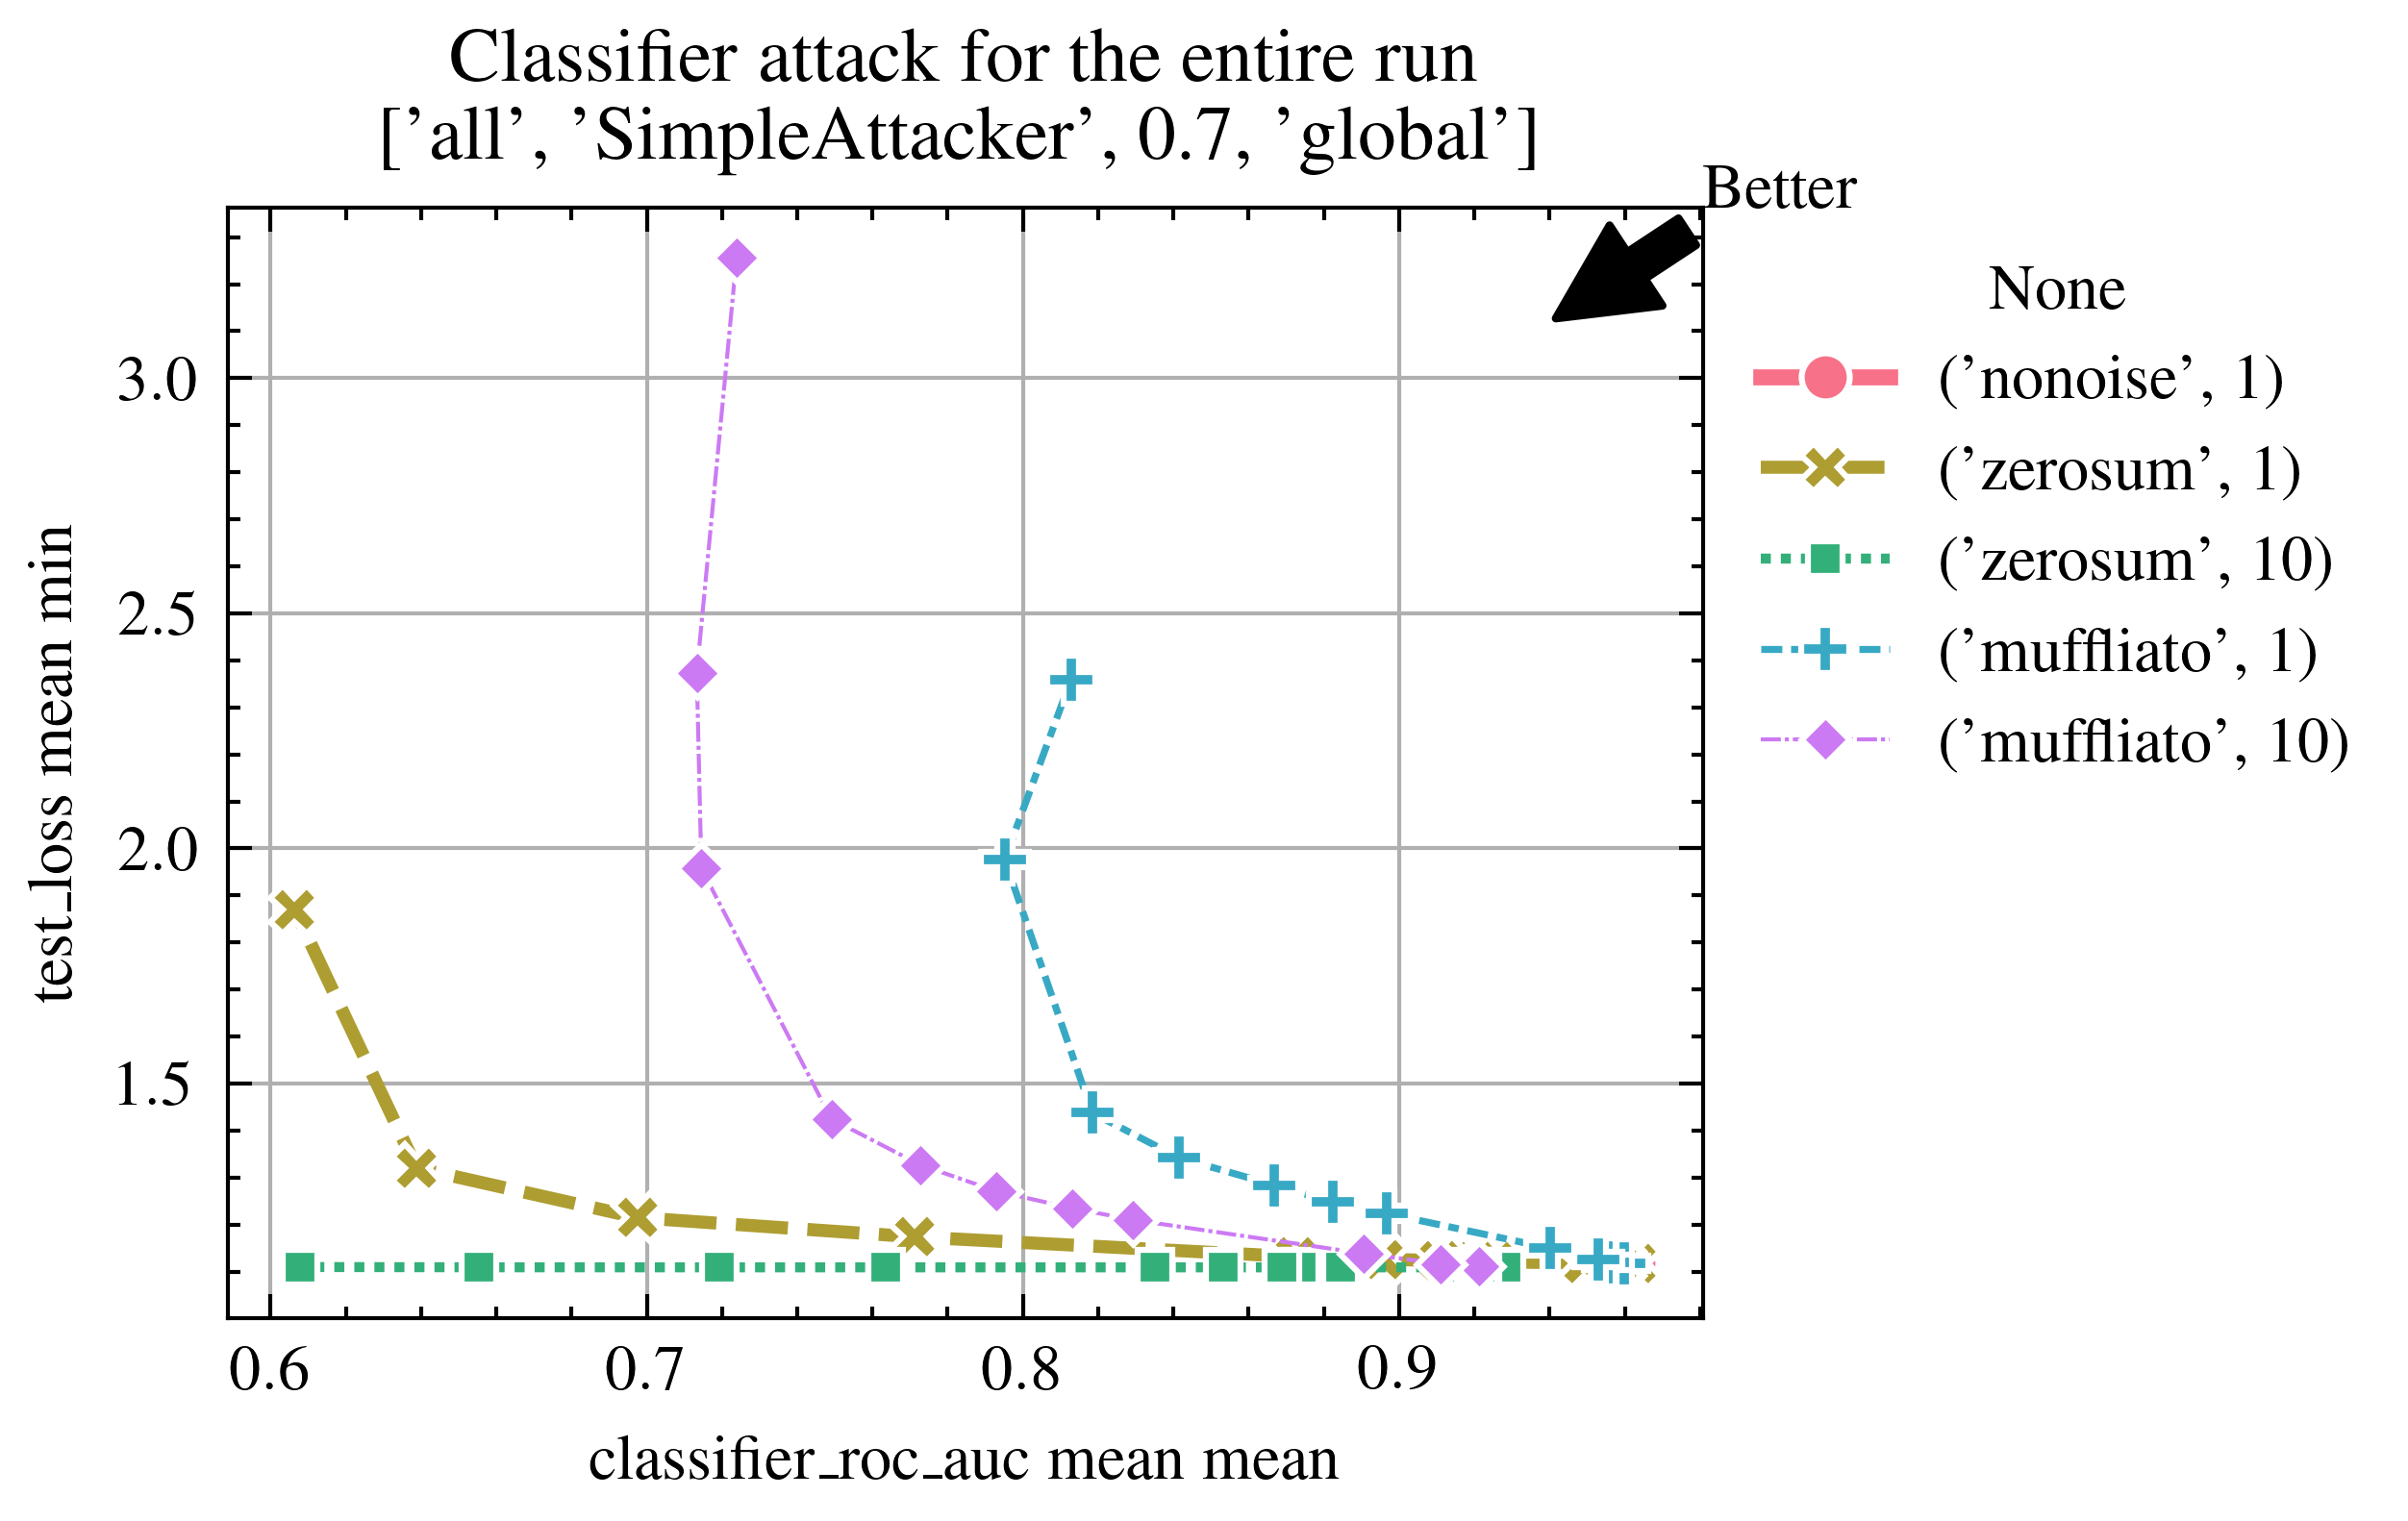

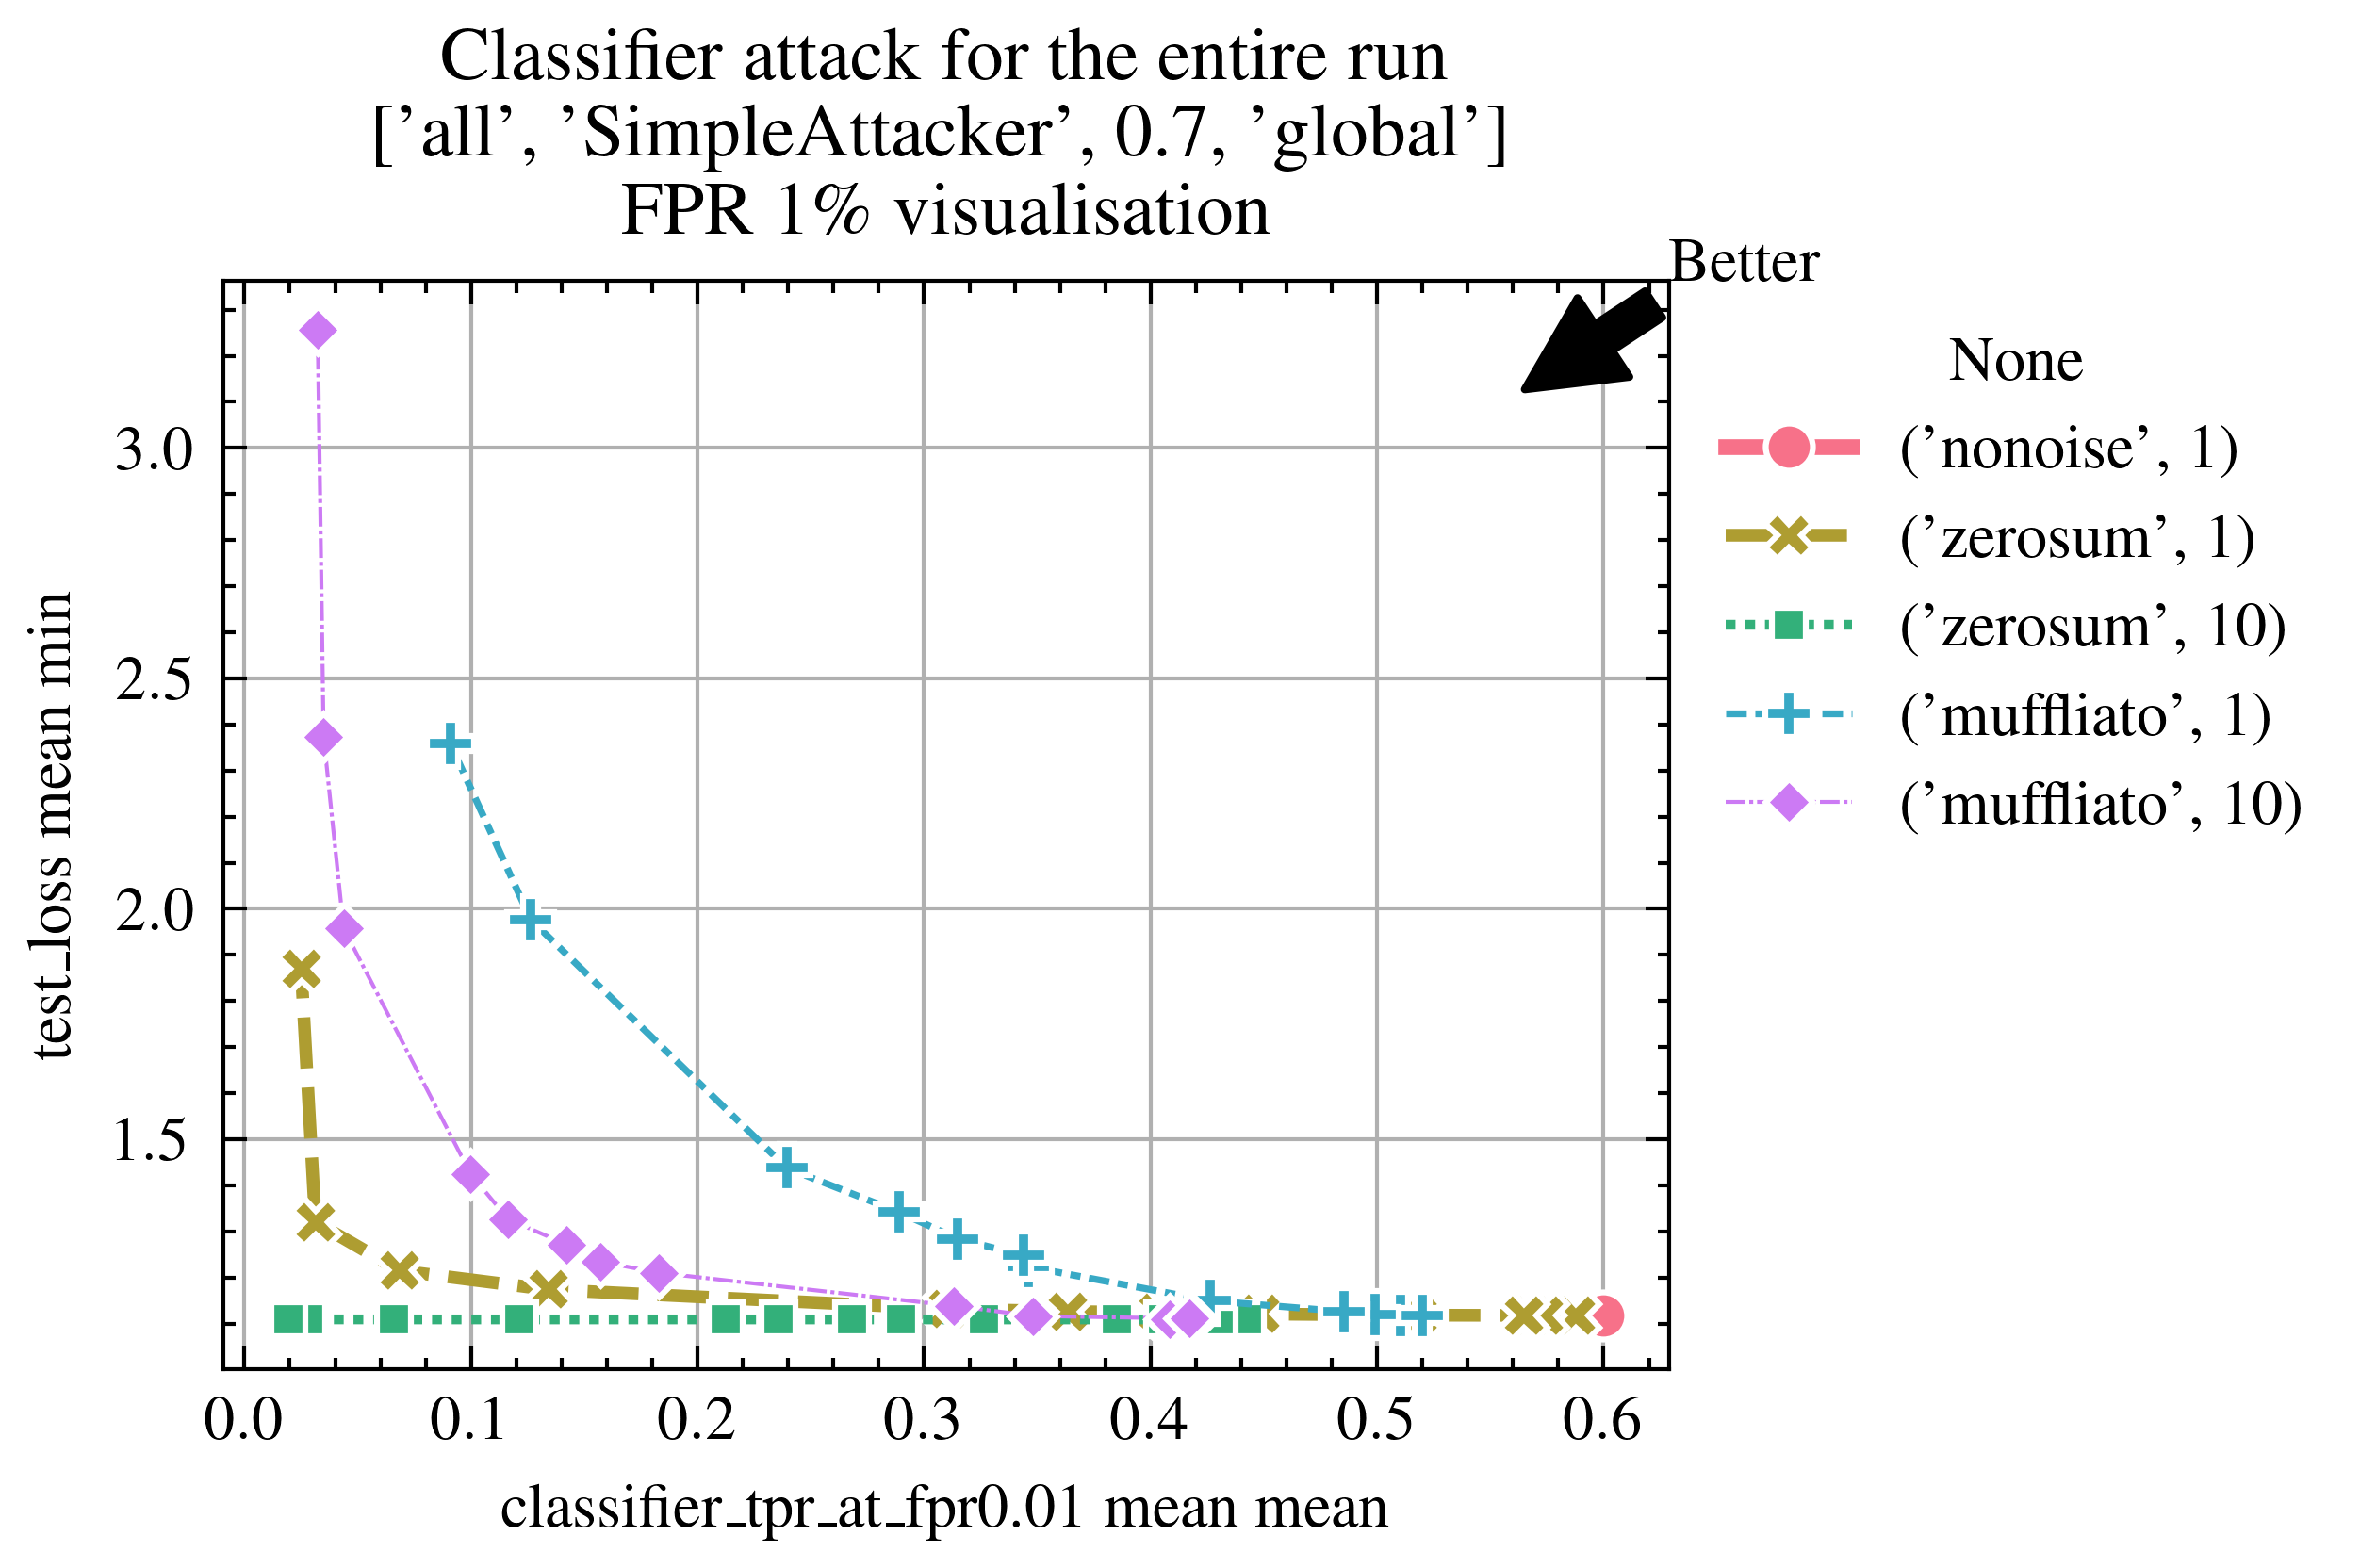

In [7]:
importlib.reload(plot_loaders)
importlib.reload(plot_utils)
# Aggregation of each experiments (across iterations)
x_method = "mean"
filter_classifier_result = ["all", "SimpleAttacker", 0.7, "global"]

# y_method = "mean"

y_axis_name = "test_loss mean"
y_method = "min"  # For movieLens, we consider the minimum test loss.
arrow_position = "top right"

# y_axis_name = "test_acc mean"
# y_method = "max" # We often consider the maximum accuracy
# arrow_position = "bottom right"

nonoise_attributes = {
    "variant": ["nonoise"],
    "topology_type": ["static"],
    "avgsteps": ["1avgsteps"],
    "additional_attribute": ["nonoise"],
}

zerosum_attributes = {
    "variant": ["zerosum"],
    "topology_type": ["static"],
    "avgsteps": ["1avgsteps", "10avgsteps"],
    "additional_attribute": ["selfnoise"],
}

muffliato_attributes = {
    "variant": ["muffliato"],
    "topology_type": ["static"],
    "avgsteps": ["1avgsteps", "10avgsteps"],
}


name_formater = {"test_acc mean max": "Maximum test accuracy [%]", "nonoise": "test"}


current_attributes = [nonoise_attributes, zerosum_attributes, muffliato_attributes]

display_attributes = {
    "hue": ["variant", "avgsteps"],
    "style": ["variant", "avgsteps"],
    "size": [
        "variant",
        "avgsteps",
    ],  # For some reason having both style and size breaks in this case.
    # "col":"clipping_norm",# Cannot have col argument for the lineplot function
}

zerosum_experiments = plot_loaders.filter_attribute_list(
    experiments_attributes, current_attributes
)
for experiment in sorted(zerosum_experiments):
    print(experiment)


plt.figure()
plot_utils.scatter_averaged_experiments(
    plot_loaders.filter_classifier(formatted_data, *filter_classifier_result),
    zerosum_experiments,
    display_attributes,
    f"Classifier attack for the entire run\n {filter_classifier_result}",
    y_axis_name=y_axis_name,
    x_axis_name="classifier_roc_auc mean",
    save_directory=save_directory,
    y_method=y_method,
    x_method=x_method,
    orderings=ORDERINGS,
    name_formater=name_formater,
    arrow_position=arrow_position,
)
plt.figure()
plot_utils.scatter_averaged_experiments(
    plot_loaders.filter_classifier(formatted_data, *filter_classifier_result),
    zerosum_experiments,
    display_attributes,
    f"Classifier attack for the entire run\n{filter_classifier_result}\n FPR 1\% visualisation",
    y_axis_name=y_axis_name,
    x_axis_name="classifier_tpr_at_fpr0.01 mean",
    save_directory=save_directory,
    y_method=y_method,
    x_method=x_method,
    orderings=ORDERINGS,
    name_formater=name_formater,
    arrow_position=arrow_position,
)

Loss Attack (or Threshold attack):

['2500318_movielens_nonoise_1avgsteps_static_seed1234_MatrixFactorization_lr0.075_batchsize32', '2500320_movielens_zerosum_selfnoise_1avgsteps_128th_static_seed1234_MatrixFactorization_lr0.075_batchsize32', '2500322_movielens_zerosum_selfnoise_1avgsteps_64th_static_seed1234_MatrixFactorization_lr0.075_batchsize32', '2500324_movielens_zerosum_selfnoise_1avgsteps_32th_static_seed1234_MatrixFactorization_lr0.075_batchsize32', '2500328_movielens_zerosum_selfnoise_1avgsteps_16th_static_seed1234_MatrixFactorization_lr0.075_batchsize32', '2500330_movielens_zerosum_selfnoise_1avgsteps_8th_static_seed1234_MatrixFactorization_lr0.075_batchsize32', '2500332_movielens_zerosum_selfnoise_1avgsteps_4th_static_seed1234_MatrixFactorization_lr0.075_batchsize32', '2500334_movielens_zerosum_selfnoise_1avgsteps_2th_static_seed1234_MatrixFactorization_lr0.075_batchsize32', '2500336_movielens_zerosum_selfnoise_1avgsteps_1th_static_seed1234_MatrixFactorization_lr0.075_batchsize32', '2500338_movielens_zerosum_

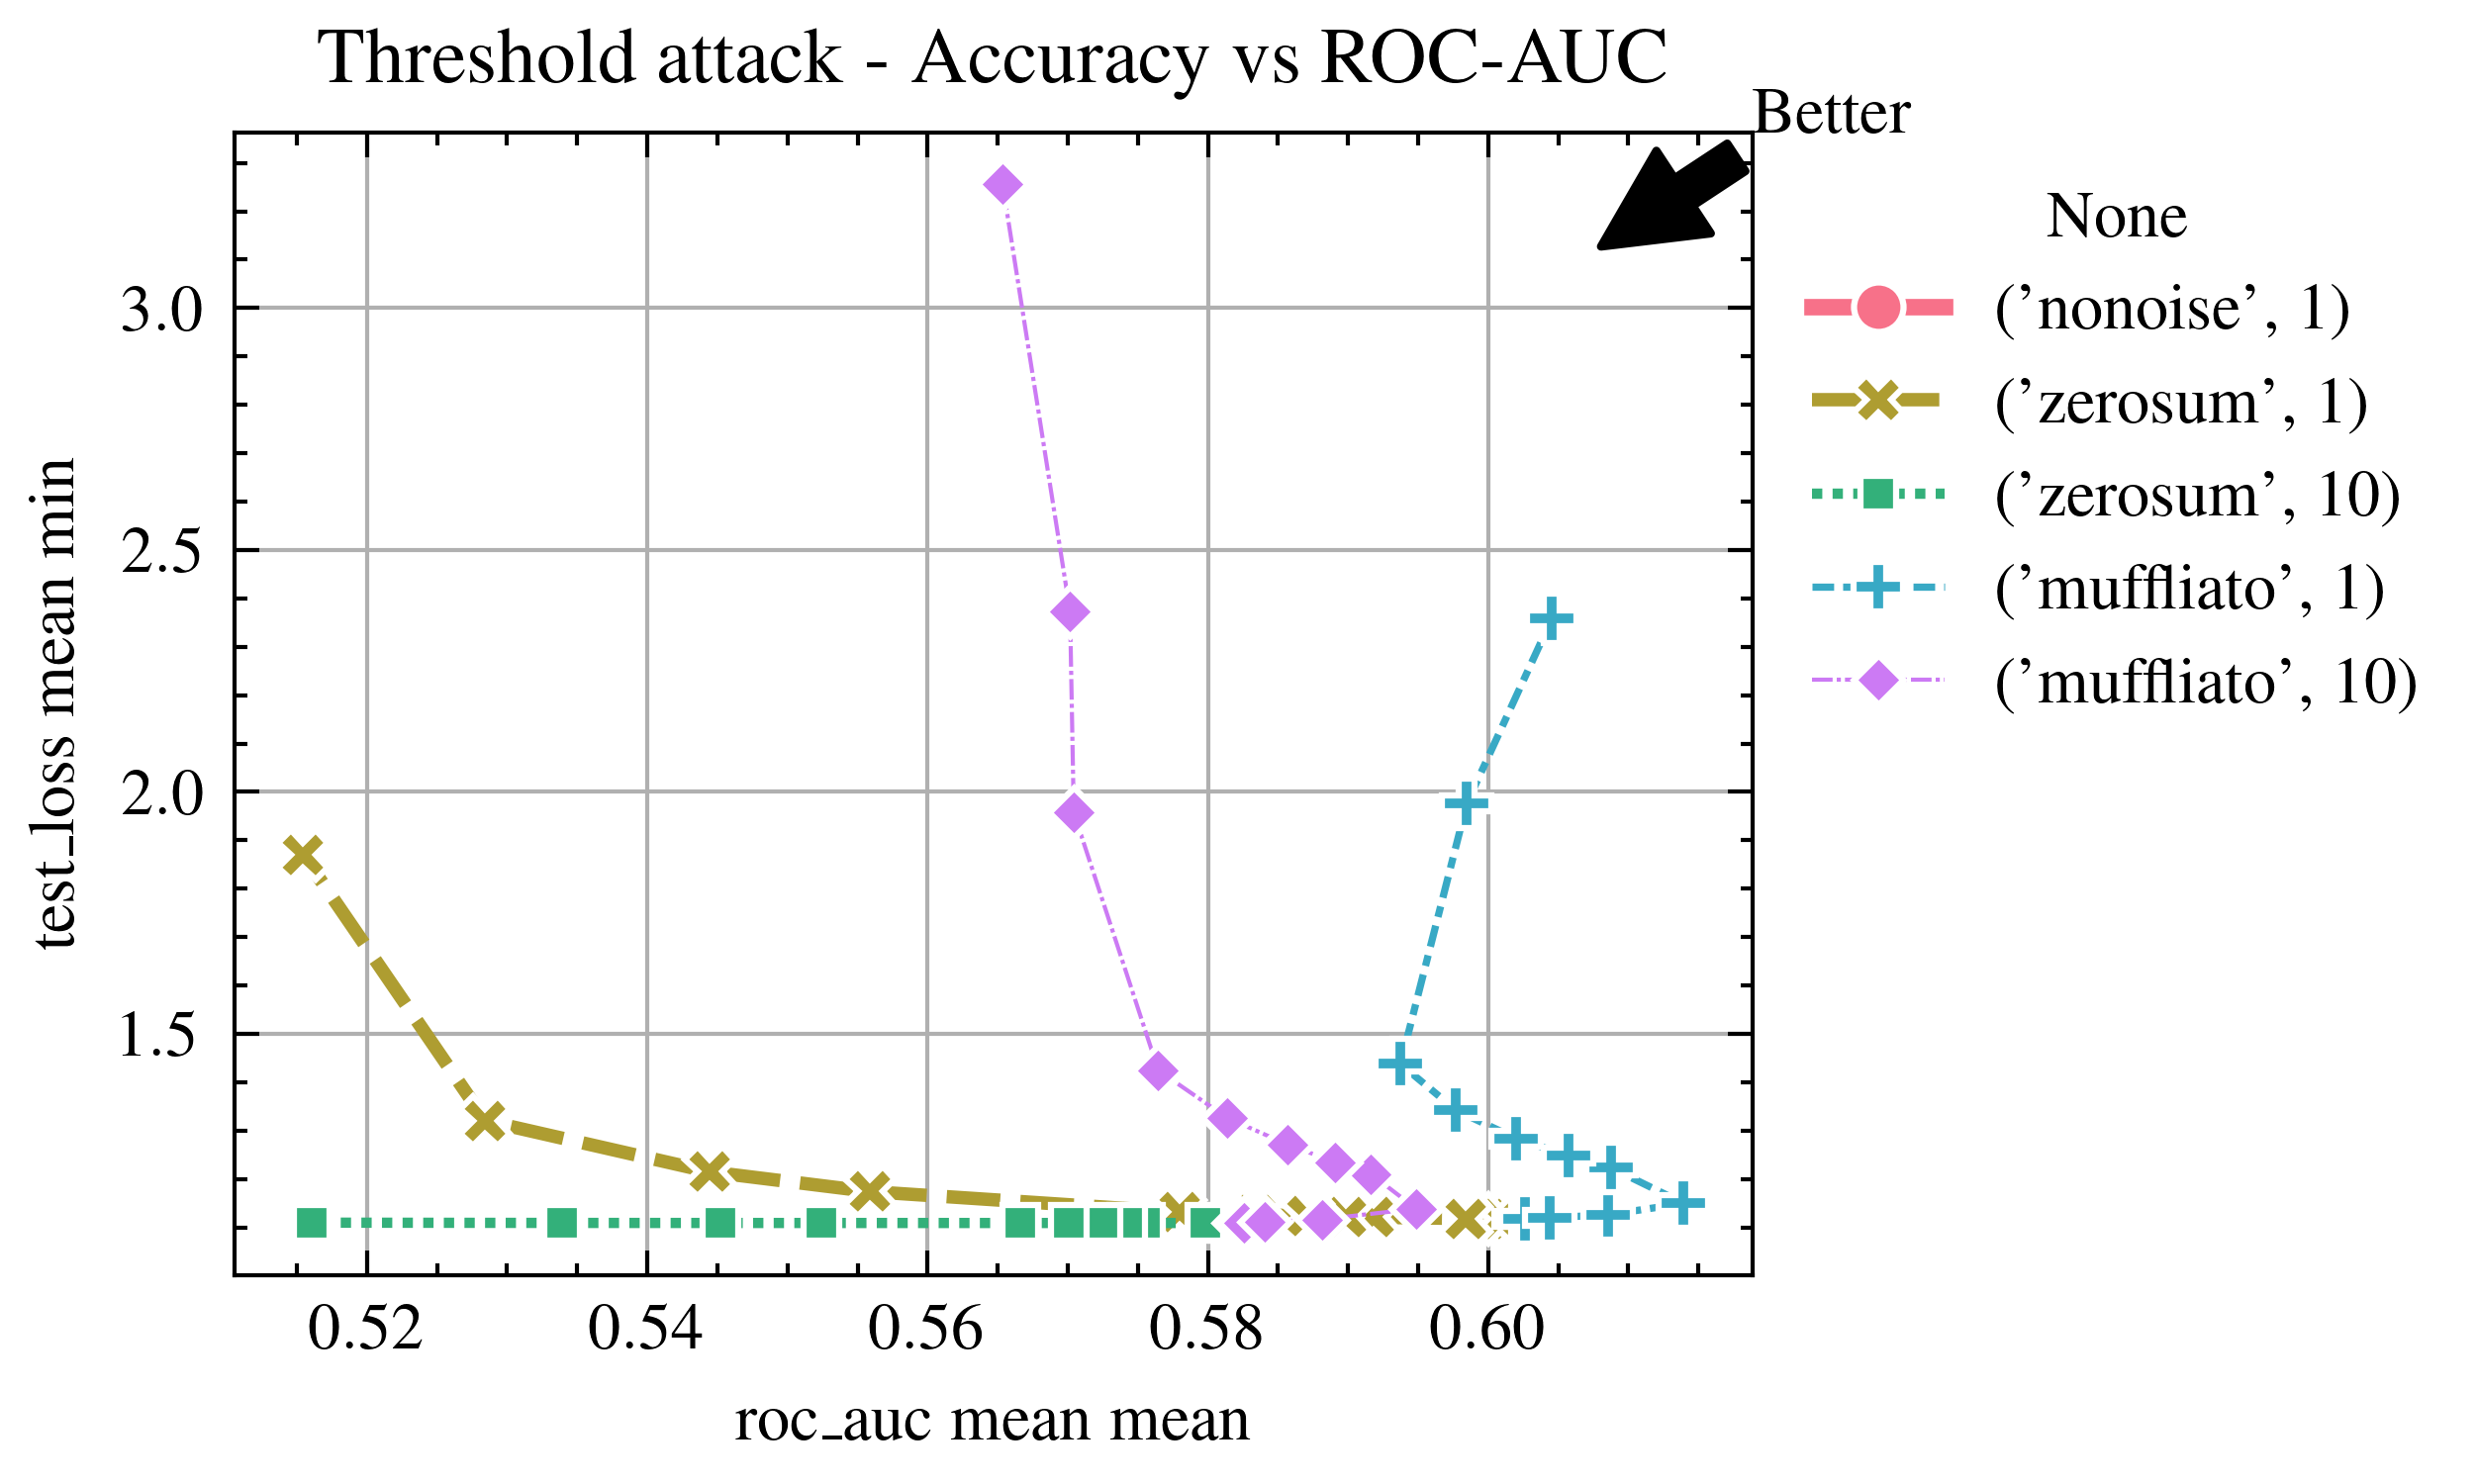

In [8]:
print(zerosum_experiments)
plt.figure()
plot_utils.scatter_averaged_experiments(
    formatted_data,
    zerosum_experiments,
    display_attributes,
    "Threshold attack - Accuracy vs ROC-AUC ",
    y_axis_name=y_axis_name,
    x_axis_name="roc_auc mean",
    save_directory=save_directory,
    y_method=y_method,
    x_method=x_method,
    orderings=ORDERINGS,
    name_formater=name_formater,
    arrow_position=arrow_position,
)


# Second type of plots: Communication usage displays
Displays of the data needed to reach a given target (mostly accuracy, for the 50% target accuracy)

2500318_movielens_nonoise_1avgsteps_static_seed1234_MatrixFactorization_lr0.075_batchsize32
2500320_movielens_zerosum_selfnoise_1avgsteps_128th_static_seed1234_MatrixFactorization_lr0.075_batchsize32
2500322_movielens_zerosum_selfnoise_1avgsteps_64th_static_seed1234_MatrixFactorization_lr0.075_batchsize32
2500324_movielens_zerosum_selfnoise_1avgsteps_32th_static_seed1234_MatrixFactorization_lr0.075_batchsize32
2500328_movielens_zerosum_selfnoise_1avgsteps_16th_static_seed1234_MatrixFactorization_lr0.075_batchsize32
2500330_movielens_zerosum_selfnoise_1avgsteps_8th_static_seed1234_MatrixFactorization_lr0.075_batchsize32
2500332_movielens_zerosum_selfnoise_1avgsteps_4th_static_seed1234_MatrixFactorization_lr0.075_batchsize32
2500334_movielens_zerosum_selfnoise_1avgsteps_2th_static_seed1234_MatrixFactorization_lr0.075_batchsize32
2500336_movielens_zerosum_selfnoise_1avgsteps_1th_static_seed1234_MatrixFactorization_lr0.075_batchsize32
2500338_movielens_zerosum_selfnoise_1avgsteps_0p25th_st

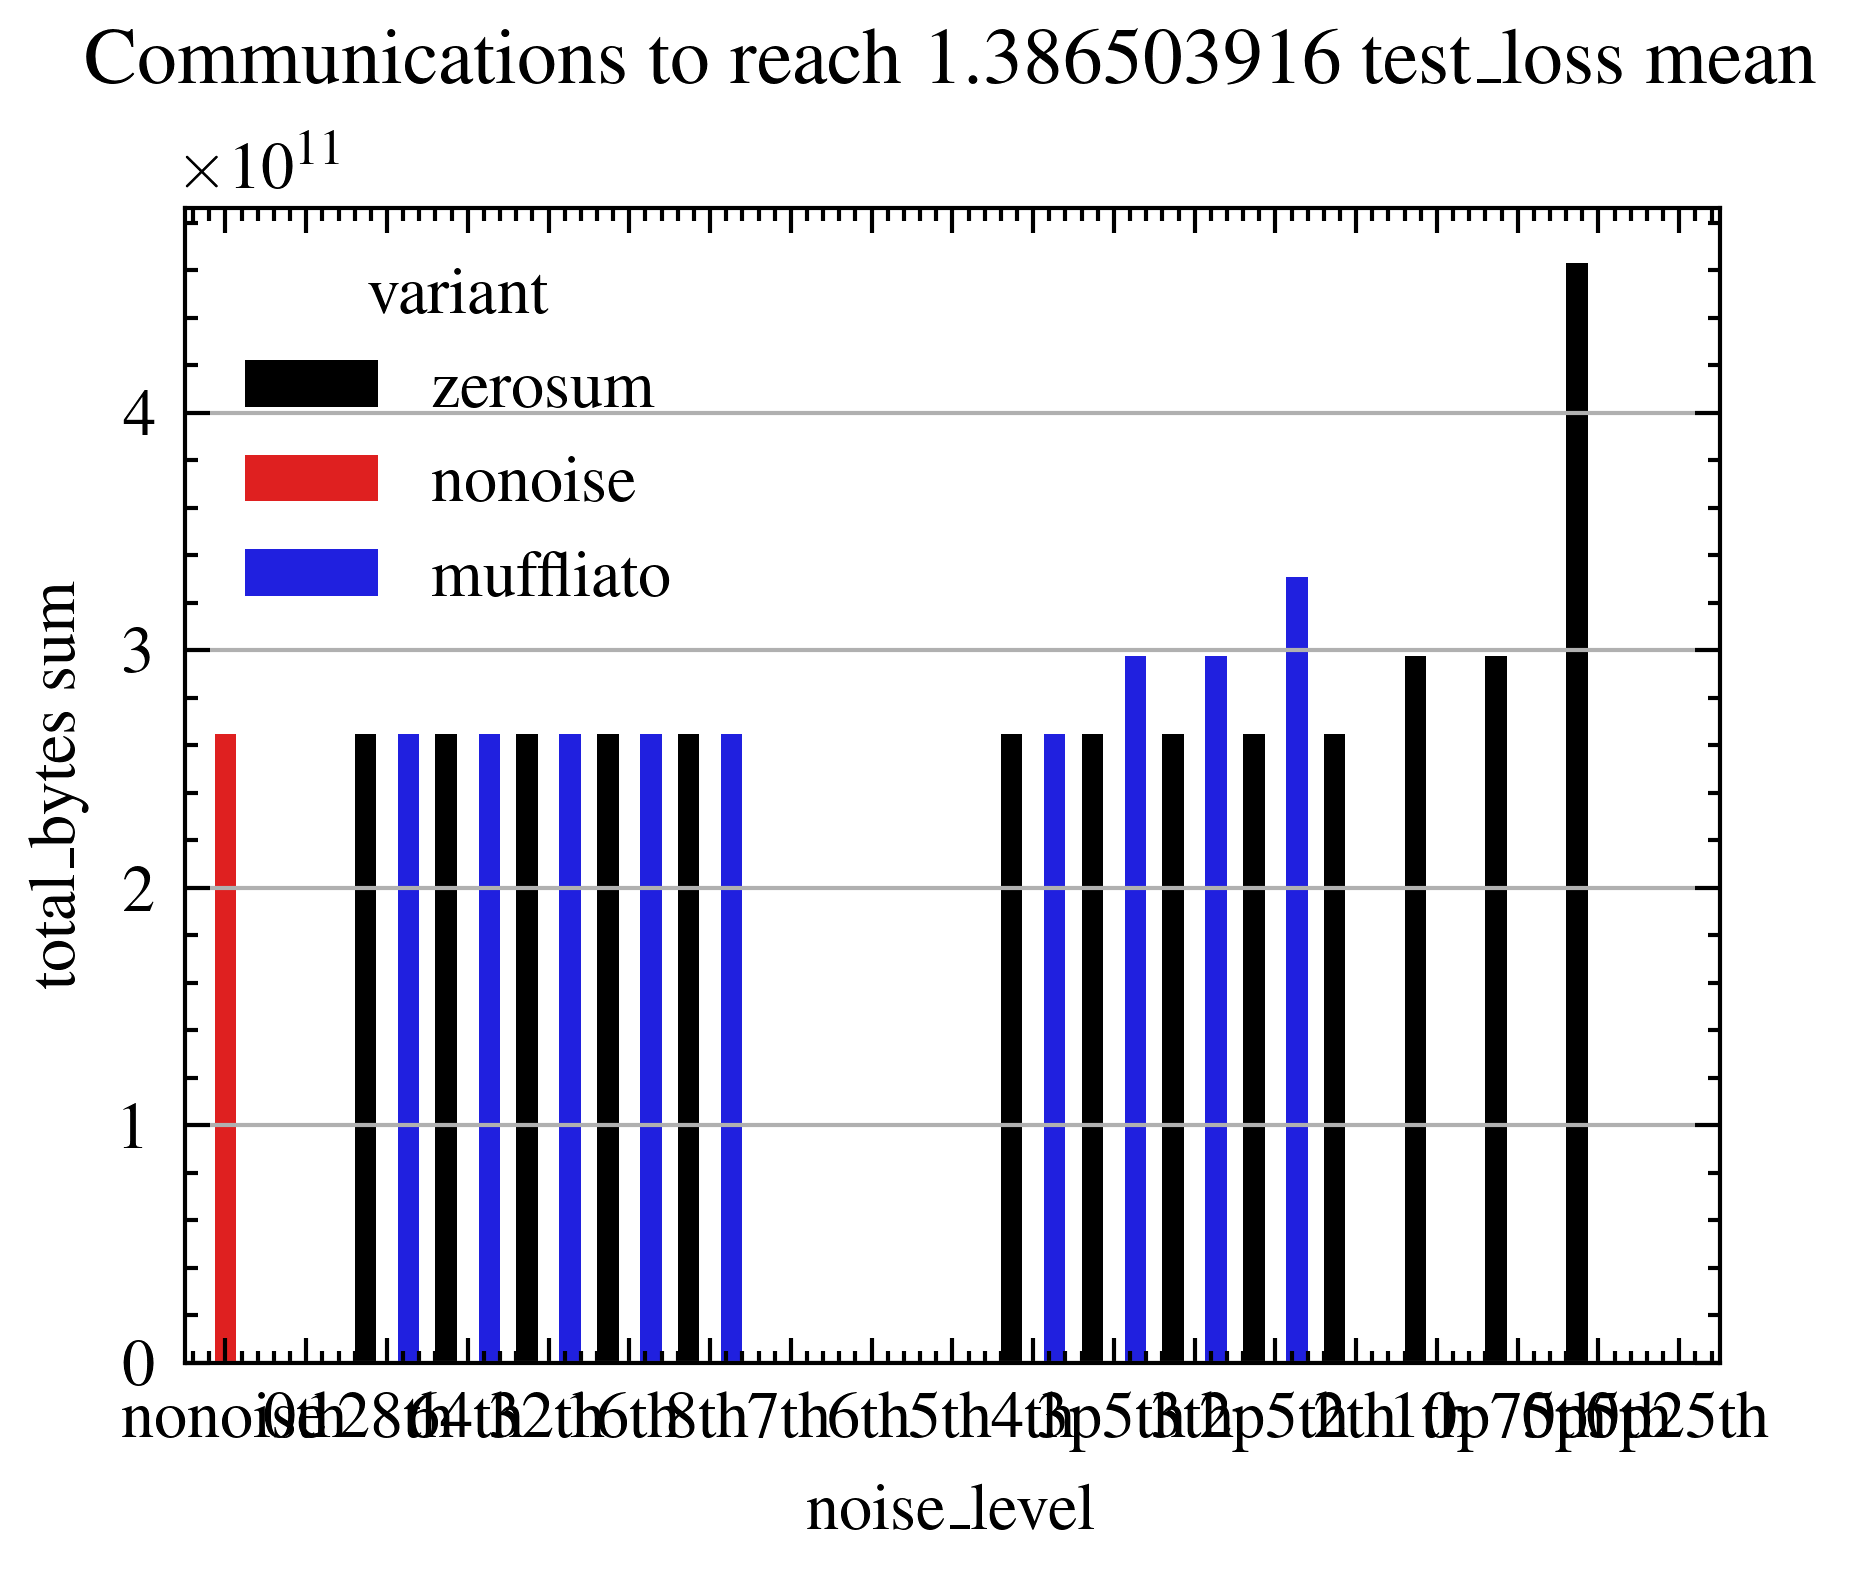

In [9]:
importlib.reload(plot_utils)

# For CIFAR
# target_accuracy = 50
# accuracy_metric = "test_acc mean"

# MovieLens
# Those values were hard computed, as described in the paper.
# Those values are 1.25x the best test loss for no noise on MovieLens.
target_accuracy = 1.386503916 # 1 step
# target_accuracy = 1.374679439 # 10 steps
accuracy_metric = "test_loss mean"


zerosum_attributes = {
    "variant": ["nonoise", "zerosum"],
    "topology_type": ["static"],
    "avgsteps": ["1avgsteps"],
    "additional_attribute": ["nonoise", "selfnoise"],
}

muffliato_attributes = {
    "variant": ["muffliato"],
    "topology_type": ["static"],
    "avgsteps": ["1avgsteps"],
}
current_attributes = [zerosum_attributes, muffliato_attributes]

zerosum_experiments = plot_loaders.filter_attribute_list(
    experiments_attributes, current_attributes
)
for experiment in sorted(zerosum_experiments):
    print(experiment)
order = ORDERINGS["noise_level"]
order_mapper = {"muffliato": 2, "nonoise": 1, "zerosum": 0}
zerosum_experiments = sorted(
    zerosum_experiments, key=lambda x: order_mapper[x.split("_")[2]]
)

plot_utils.plot_communication(
    formatted_data,
    zerosum_experiments,
    target_accuracy,
    f"Communications to reach {target_accuracy} {accuracy_metric}",
    accuracy_metric=accuracy_metric,
    save_directory=save_directory,
    order=order,
)